In [1]:
# Mount Google Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    USING_COLAB = True
except:
    USING_COLAB = False

In [2]:
import os
import sys
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
# import warnings
# warnings.filterwarnings('ignore')
from typing import Dict, List, Tuple, Optional, Any

In [3]:
import joblib
import psutil
import torch
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix,
    classification_report, roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)
from datetime import datetime

In [4]:
# if USING_COLAB:
#     from thundersvm import SVC  # ThunderSVM
#     print("ThunderSVM importado correctamente.")
# else:
#     from sklearn.svm import SVC  # Fallback a scikit-learn
#     print("ThunderSVM no disponible, usando sklearn SVC.")
from sklearn.svm import SVC  # Fallback a scikit-learn

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from tqdm import tqdm

In [7]:
from torch.utils.data import Dataset
from torch.nn.parallel import DataParallel

In [34]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

In [35]:
spanish_stopwords = stopwords.words('spanish')

In [8]:
# Configuración de logging
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

In [9]:
if USING_COLAB:
    results_dir = "/content/drive/My Drive/GTSI/Codigos_proyectos_carrera/results"
    plots_dir = "/content/drive/My Drive/GTSI/Codigos_proyectos_carrera/plots"
    data_dir = "/content/drive/My Drive/GTSI/Codigos_proyectos_carrera/data"
    models_dir = "/content/drive/My Drive/GTSI/Codigos_proyectos_carrera/models"
    sufix = "colab"
else:
    results_dir = "./results"
    plots_dir = "./plots"
    data_dir = "./data"
    models_dir = "./models"
    sufix = "colab"

# 1. Análisis del sistema

In [10]:
def get_system_info():
    """Obtener información del sistema"""
    info = {
        'cpu_count': psutil.cpu_count(),
        'cpu_count_logical': psutil.cpu_count(logical=True),
        'memory_total_gb': psutil.virtual_memory().total / (1024**3),
        'memory_available_gb': psutil.virtual_memory().available / (1024**3),
        'gpu_available': torch.cuda.is_available(),
        'gpu_count': torch.cuda.device_count() if torch.cuda.is_available() else 0,
    }

    if info['gpu_available']:
        gpu_info = []
        for i in range(info['gpu_count']):
            gpu_props = torch.cuda.get_device_properties(i)
            gpu_info.append({
                'name': gpu_props.name,
                'memory_total_gb': gpu_props.total_memory / (1024**3),
                'compute_capability': f"{gpu_props.major}.{gpu_props.minor}"
            })
        info['gpu_details'] = gpu_info

    return info

In [11]:
def recommend_batch_size(model_name: str = 'roberta-base') -> int:
    """Recomendar tamaño de batch basado en recursos disponibles"""
    if not torch.cuda.is_available():
        return 8  # CPU

    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)

    # Recomendaciones basadas en memoria GPU
    # if gpu_memory >= 24:  # RTX 4090, A100, etc.
    #     return 32 if 'large' not in model_name else 16
    # elif gpu_memory >= 16:  # RTX 4080, V100, etc.
    #     return 24 if 'large' not in model_name else 12
    # elif gpu_memory >= 12:  # RTX 4070 Ti, RTX 3080 Ti, etc.
    #     return 16 if 'large' not in model_name else 8
    # elif gpu_memory >= 8:   # RTX 4060 Ti, RTX 3070, etc.
    #     return 12 if 'large' not in model_name else 6
    # else:  # GPUs más pequeñas
    #     return 8 if 'large' not in model_name else 4
    return 8

In [12]:
"""Imprimir reporte del sistema"""
info = get_system_info()

print("="*60)
print("REPORTE DEL SISTEMA")
print("="*60)
print(f"CPU: {info['cpu_count']} cores físicos, {info['cpu_count_logical']} lógicos")
print(f"RAM: {info['memory_total_gb']:.1f} GB total, {info['memory_available_gb']:.1f} GB disponible")

if info['gpu_available']:
    print(f"\nGPUs disponibles: {info['gpu_count']}")
    for i, gpu in enumerate(info['gpu_details']):
        print(f"  GPU {i}: {gpu['name']}")
        print(f"    Memoria: {gpu['memory_total_gb']:.1f} GB")
        print(f"    Compute Capability: {gpu['compute_capability']}")
else:
    print("\nNo hay GPUs disponibles")

print(f"\nBatch size recomendado: {recommend_batch_size()}")
print("="*60)

REPORTE DEL SISTEMA
CPU: 12 cores físicos, 12 lógicos
RAM: 15.6 GB total, 3.7 GB disponible

No hay GPUs disponibles

Batch size recomendado: 8


# 2. Crear directorios en caso de no existir

In [13]:
directories = [data_dir, models_dir, results_dir, plots_dir]
for dir_path in directories:
    Path(dir_path).mkdir(exist_ok=True)
    print(f"✓ {dir_path}")

✓ ./data
✓ ./models
✓ ./results
✓ ./plots


# 3. Dataset

In [14]:
df = pd.read_csv(data_dir + "/projects_processed_colab.csv")
df.rename(columns={'CARRERA': 'value'}, inplace=True)
print(f"✓ Datos cargados: {len(df)} muestras")
print(f"✓ SDGs únicos: {df['value'].nunique()}") # Sistema de Gestión de Datos
print(f"✓ Distribución por SDG:") # Stochastic Gradient Descent
print(df['value'].value_counts().head())

✓ Datos cargados: 170000 muestras
✓ SDGs únicos: 34
✓ Distribución por SDG:
value
Ingeniería Química        5000
Logistica y Transporte    5000
Diseño Gráfico            5000
Ingeniería  Civil         5000
Economía                  5000
Name: count, dtype: int64


C:\Users\saraujo\AppData\Local\Temp\ipykernel_17944\210891862.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_dir + "/projects_processed_colab.csv")


In [15]:
if "CORPUS" in df.keys():
    print(df.keys())
    df["text_cp"] = df["text"]
    df["text"] = df["CORPUS"]
    print("Corpus cambiado a la columna text y text almacenado en text_cp, CORPUS se mantiene para almacenamiento.")
    print(df.keys())
else:
    print("Solo existe text, se mantiene la columna de text.")

Index(['text', 'FACULTAD', 'value', 'NOMBREPROYEC', 'counts', 'URL', 'ESTADO',
       'gpu_used', 'batch_id', 'CORPUS'],
      dtype='object')
Corpus cambiado a la columna text y text almacenado en text_cp, CORPUS se mantiene para almacenamiento.
Index(['text', 'FACULTAD', 'value', 'NOMBREPROYEC', 'counts', 'URL', 'ESTADO',
       'gpu_used', 'batch_id', 'CORPUS', 'text_cp'],
      dtype='object')


In [16]:
df.iloc[0]

text            preparación nano celulós utilización material ...
FACULTAD             Facultad de Ciencias Naturales y Matemáticas
value                                          Ingeniería Química
NOMBREPROYEC    Preparación de nano celulosa y su utilización ...
counts                                                       72.0
URL                                                             0
ESTADO                                                     Activa
gpu_used                                                      NaN
batch_id                                                      NaN
CORPUS          preparación nano celulós utilización material ...
text_cp         preparación de nano celulosa y su utilización ...
Name: 0, dtype: object

# 4. Análisis exploratorio

In [17]:
# Estadísticas básicas
text_lengths = df['text'].str.len()
print(f"✓ Longitud promedio de texto: {text_lengths.mean():.1f} caracteres")
print(f"✓ Longitud mínima: {text_lengths.min()}")
print(f"✓ Longitud máxima: {text_lengths.max()}")

✓ Longitud promedio de texto: 84.3 caracteres
✓ Longitud mínima: 1.0
✓ Longitud máxima: 364.0


In [18]:
df["value"].value_counts(), df["value"].shape

(value
 Ingeniería Química                            5000
 Logistica y Transporte                        5000
 Diseño Gráfico                                5000
 Ingeniería  Civil                             5000
 Economía                                      5000
 Alimentos                                     5000
 Electricidad                                  5000
 Computación                                   5000
 Electrónica y Automatización                  5000
 Tecnología Superior en Mecatrónica            5000
 Telemática                                    5000
 Mecánica                                      5000
 Nutrición y Dietética                         5000
 Producción para Medios de Comunicación        5000
 Geología                                      5000
 Mecatrónica                                   5000
 Turismo                                       5000
 Biología                                      5000
 Administración de Empresas                    5000
 Mina

In [19]:
info = {
    'total_samples': len(df),
    'unique_labels': df['value'].nunique(),
    'label_distribution': df['value'].value_counts().to_dict(),
    'text_lengths': {
        'mean': df['text'].str.len().mean(),
        'std': df['text'].str.len().std(),
        'min': df['text'].str.len().min(),
        'max': df['text'].str.len().max()
    },
    'missing_values': df.isnull().sum().to_dict()
}

# Guardar información
with open(os.path.join(results_dir, 'data_analysis.json'), 'w') as f:
    json.dump(info, f, indent=2, default=str)


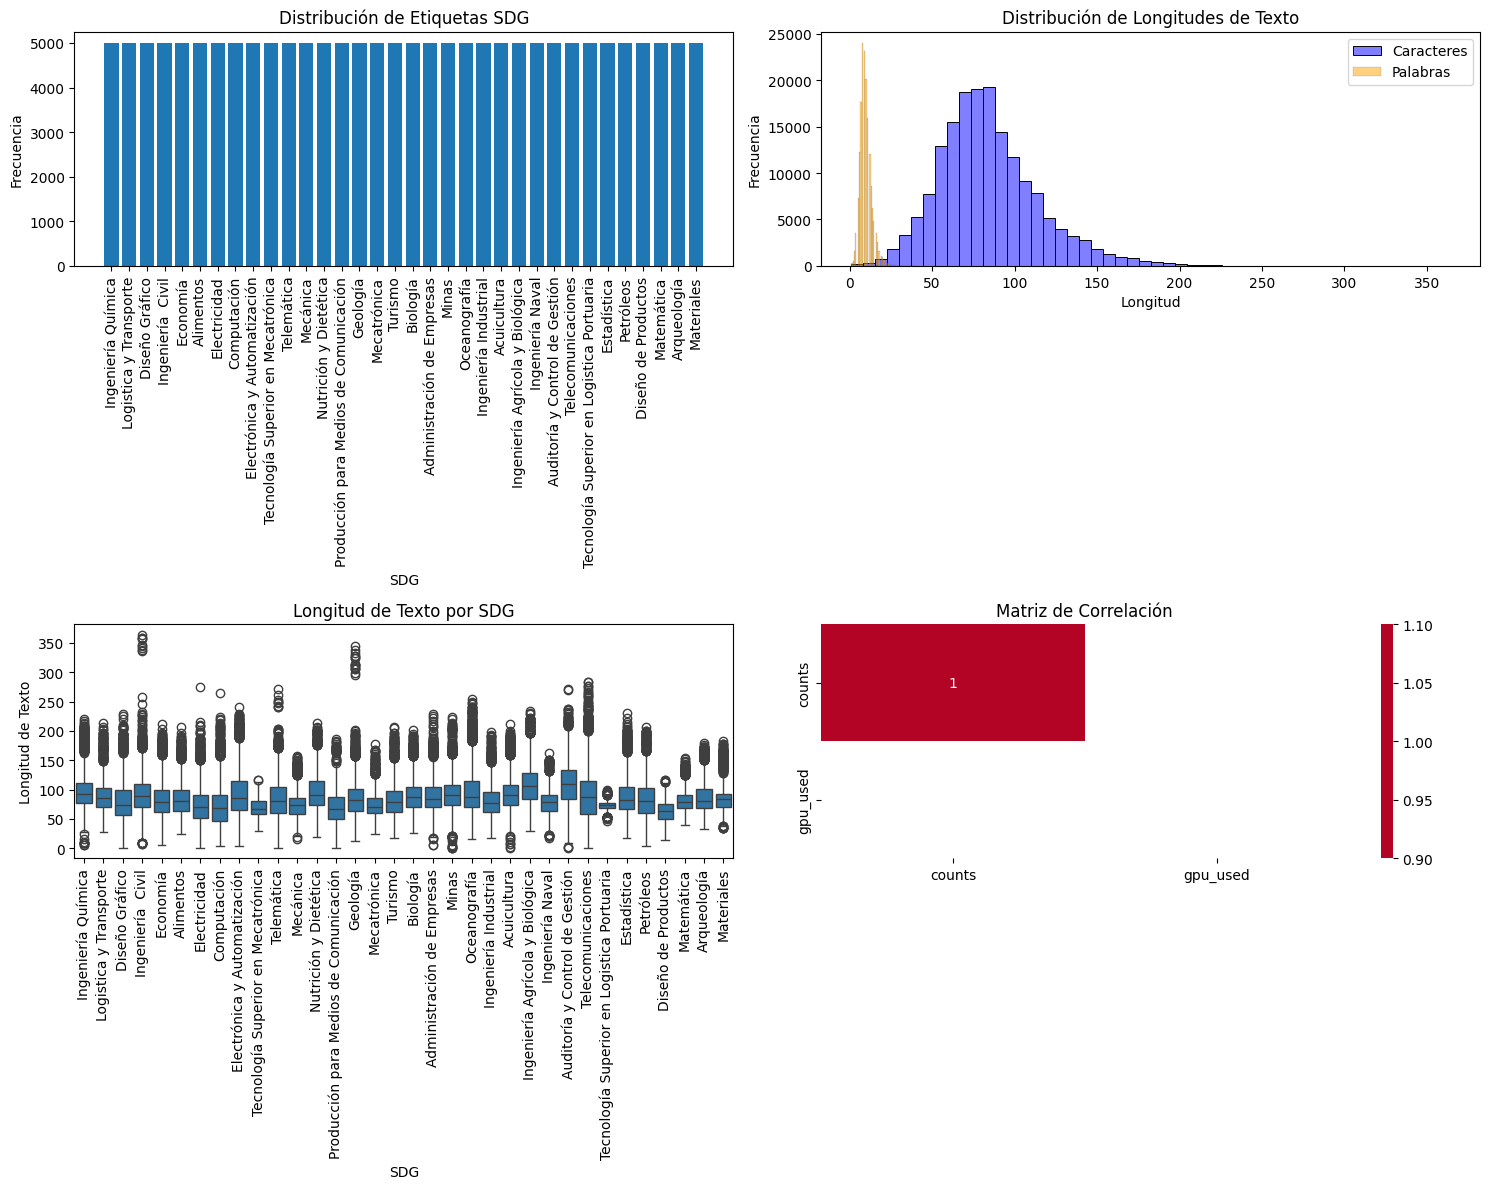

✓ Visualizaciones guardadas en ./plots\data_analysis.png


In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribución de etiquetas
label_counts = pd.Series(info['label_distribution'])
axes[0, 0].bar(label_counts.index, label_counts.values)
axes[0, 0].set_title('Distribución de Etiquetas SDG')
axes[0, 0].set_xlabel('SDG')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].tick_params(axis='x', rotation=90)

# Distribución de longitudes de texto
text_lengths_chars = df['text'].str.len() # cantidad de caracteres
text_lengths_words = df['text'].str.split().str.len() # cantidad de palabras

# axes[0, 1].hist(text_lengths, bins=50, alpha=0.7)
# axes[0, 1].set_title('Distribución de Longitudes de Texto (Caracteres)')
# axes[0, 1].set_xlabel('Longitud de Texto')
# axes[0, 1].set_ylabel('Frecuencia')
# axes[0, 1].axvline(text_lengths.mean(), color='red', linestyle='--', label=f'Media: {text_lengths.mean():.0f}')
# axes[0, 1].axvline(text_lengths.median(), color='green', linestyle='--', label=f'Mediana: {text_lengths.median():.0f}')
# # axes[0, 1].set_xlim(0, text_lengths.max() + 100)
# # axes[0, 1].set_ylim(0, text_lengths.value_counts().max() + 100)
# axes[0, 1].legend()
sns.histplot(text_lengths_chars, bins=50, color='blue', alpha=0.5, label='Caracteres', ax=axes[0, 1])
sns.histplot(text_lengths_words, bins=50, color='orange', alpha=0.5, label='Palabras', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Longitudes de Texto')
axes[0, 1].set_xlabel('Longitud')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].legend()

# Boxplot de longitudes por SDG
df_plot = df.copy()
df_plot['text_length'] = df_plot['text'].str.len()
sns.boxplot(data=df_plot, x='value', y='text_length', ax=axes[1, 0])
axes[1, 0].set_title('Longitud de Texto por SDG')
axes[1, 0].set_xlabel('SDG')
axes[1, 0].set_ylabel('Longitud de Texto')
axes[1, 0].tick_params(axis='x', rotation=90)

# Heatmap de correlación (si hay más columnas numéricas)
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
    axes[1, 1].set_title('Matriz de Correlación')
else:
    axes[1, 1].text(0.5, 0.5, 'No hay suficientes\nvariables numéricas\npara correlación',
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Matriz de Correlación')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'data_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Visualizaciones guardadas en", os.path.join(plots_dir, 'data_analysis.png'))


In [21]:
print("Análisis de datos completado.")
print("Cantidad de muestras:", len(df))
print("Cantidad de palabras *********")
print("Minimo:", text_lengths_words.min())
print("Máximo:", text_lengths_words.max())
print("Media:", text_lengths_words.mean())
print("Mediana", text_lengths_words.median())
print("Cantidad de caracteres *********")
print("Minimo:", text_lengths_chars.min())
print("Máximo:", text_lengths_chars.max())
print("Media:", text_lengths_chars.mean())
print("Mediana", text_lengths_chars.median())

Análisis de datos completado.
Cantidad de muestras: 170000
Cantidad de palabras *********
Minimo: 1.0
Máximo: 40.0
Media: 9.788919758899981
Mediana 9.0
Cantidad de caracteres *********
Minimo: 1.0
Máximo: 364.0
Media: 84.2984495667734
Mediana 80.0


# 5. Optimización de configuración

In [22]:
def optimize_config(base_config):
    """Optimizar configuración basada en recursos disponibles"""
    system_info = get_system_info()
    optimized = base_config.copy()

    # Optimizar batch size
    if system_info['gpu_available']:
        gpu_memory = system_info['gpu_details'][0]['memory_total_gb']
        optimized['batch_size'] = recommend_batch_size()

        # Ajustar número de workers
        optimized['num_workers'] = min(system_info['cpu_count'], 8)

        # Habilitar optimizaciones GPU
        optimized['fp16'] = True
        optimized['dataloader_pin_memory'] = True

        # Multi-GPU
        if system_info['gpu_count'] > 1:
            optimized['multi_gpu'] = True
            optimized['batch_size'] *= system_info['gpu_count']
    else:
        # Configuración para CPU
        optimized['batch_size'] = 8
        optimized['num_workers'] = system_info['cpu_count']
        optimized['fp16'] = False
        optimized['dataloader_pin_memory'] = False

    # Ajustar épocas basado en tamaño del dataset
    if 'dataset_size' in base_config:
        if base_config['dataset_size'] < 10000:
            optimized['num_epochs'] = 15
        elif base_config['dataset_size'] < 5000:
            optimized['num_epochs'] = 10
        else:
            optimized['num_epochs'] = 5

    return optimized

In [23]:
def get_device():
    """Detecta el mejor dispositivo disponible"""
    if torch.cuda.is_available():
        return f"cuda:{torch.cuda.current_device()}"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

In [24]:
base_config = {
    'dataset_size': len(df),
    'test_size': 0.2,
    'val_size': 0.2,  # Del conjunto de entrenamiento
    'random_state': 42,  # Fijar semilla para reproducibilidad
    'warmup_steps': 500,
    'weight_decay': 0.01,
    'early_stopping_patience': 3,

    # Configuración de GPU
    "device": get_device(),
    "use_gpu": torch.cuda.is_available(),
    "multi_gpu": torch.cuda.device_count() > 1,

    # Configuración de modelos tradicionales
    "traditional_use_gpu": False,

    # Configuración de transformers
    "transformer_use_gpu": torch.cuda.is_available(),
    'max_length': 512,
    'batch_size': 16 if torch.cuda.is_available() else 8,
    'num_epochs': 3,
    'learning_rate': 2e-5,

    # Logging
    'use_wandb': False,  # Cambiar a True para usar Weights & Biases
    'save_plots': True,
    'verbose': True,

    # MODELS TRANSFORMERS
    "models_to_train": {
        'roberta': 'roberta-base',
        'bert': 'bert-base-uncased',
        'distilbert': 'distilbert-base-uncased'
    }
}
base_config['num_gpus'] = torch.cuda.device_count() if base_config['use_gpu'] else 0

optimized_config = optimize_config(base_config)
print("Configuración optimizada:")
for key, value in optimized_config.items():
    print(f"  {key}: {value}")

Configuración optimizada:
  dataset_size: 170000
  test_size: 0.2
  val_size: 0.2
  random_state: 42
  warmup_steps: 500
  weight_decay: 0.01
  early_stopping_patience: 3
  device: cpu
  use_gpu: False
  multi_gpu: False
  traditional_use_gpu: False
  transformer_use_gpu: False
  max_length: 512
  batch_size: 8
  num_epochs: 5
  learning_rate: 2e-05
  use_wandb: False
  save_plots: True
  verbose: True
  models_to_train: {'roberta': 'roberta-base', 'bert': 'bert-base-uncased', 'distilbert': 'distilbert-base-uncased'}
  num_gpus: 0
  num_workers: 12
  fp16: False
  dataloader_pin_memory: False


# 6. Procesamiento

In [25]:
def clean_data(df):
    count_prev = len(df)
    print(f"Limpiando y preprocesando datos {count_prev} muestras")
    
    """Limpiar y preprocesar datos"""
    print("Limpiando datos...")

    # Eliminar filas con valores nulos
    df['text'] = df['text'].dropna()

    # Convertir texto a string
    df['text'] = df['text'].astype(str)

    # minusculas
    df['text'] = df['text'].str.lower()

    # Filtrar textos muy cortos
    df = df[df['text'].str.len() >= 10]

    count_final = len(df)
    print(f"Datos después de limpieza: {len(df)} muestras")
    print(f"Datos limpiados: {count_prev} -> {count_final} muestras {count_prev - count_final}")
    return df

In [26]:
df = clean_data(df)

Limpiando y preprocesando datos 170000 muestras
Limpiando datos...
Datos después de limpieza: 169600 muestras
Datos limpiados: 170000 -> 169600 muestras 400


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169600 entries, 0 to 169999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   text          169600 non-null  object 
 1   FACULTAD      169600 non-null  object 
 2   value         169600 non-null  object 
 3   NOMBREPROYEC  169600 non-null  object 
 4   counts        19399 non-null   float64
 5   URL           19399 non-null   object 
 6   ESTADO        19399 non-null   object 
 7   gpu_used      150201 non-null  float64
 8   batch_id      150201 non-null  object 
 9   CORPUS        169600 non-null  object 
 10  text_cp       169600 non-null  object 
dtypes: float64(2), object(9)
memory usage: 15.5+ MB


In [28]:
def split_data(df):
    """Dividir datos en entrenamiento, validación y prueba"""
    print("Dividiendo datos...")

    # Primera división: train+val vs test
    X = df['text'].values
    y = df['value'].values

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=base_config["test_size"],
        random_state=base_config["random_state"],
        stratify=y
    )

    # Segunda división: train vs val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=base_config["val_size"],
        random_state=base_config["random_state"],
        stratify=y_temp
    )

    # Crear DataFrames
    train_df = pd.DataFrame({'text': X_train, 'value': y_train})
    val_df = pd.DataFrame({'text': X_val, 'value': y_val})
    test_df = pd.DataFrame({'text': X_test, 'value': y_test})

    print(f"División de datos - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

    return train_df, val_df, test_df

In [29]:
train_df, val_df, test_df = split_data(df)

Dividiendo datos...
División de datos - Train: 108544, Val: 27136, Test: 33920


# 7. Entrenamiento

In [30]:
logger.info("Iniciando pipeline de entrenamiento...")
start_time = time.time()

2025-08-01 15:56:55,517 - INFO - Iniciando pipeline de entrenamiento...


### Entrenar modelos aprendizaje automatico

In [31]:
def save_traditional_model(model, vectorizer, model_name, results_dict):
    """Guarda modelo tradicional y sus componentes"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = f"{models_dir}/traditional/{model_name}_{timestamp}"
    os.makedirs(model_dir, exist_ok=True)

    # Guardar modelo
    model_path = f"{model_dir}/model.pkl"
    joblib.dump(model, model_path)

    # Guardar vectorizador
    vectorizer_path = f"{model_dir}/vectorizer.pkl"
    joblib.dump(vectorizer, vectorizer_path)

    # Guardar metadatos
    metadata = {
        'model_name': model_name,
        'timestamp': timestamp,
        'val_accuracy': results_dict['val_accuracy'],
        'test_accuracy': results_dict['test_accuracy'],
        'val_f1': results_dict['val_f1'],
        'test_f1': results_dict['f1_score'],
        'gpu_used': results_dict['gpu_used'],
        'model_path': model_path,
        'vectorizer_path': vectorizer_path
    }

    metadata_path = f"{model_dir}/metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"💾 Modelo guardado en: {model_dir}")
    return model_dir

In [36]:
def train_traditional_models(train_df, val_df, test_df, use_gpu=None, save_models=True):
    """Entrenar modelos tradicionales de ML"""
    logger.info("Entrenando modelos tradicionales...")

    # Configuración de GPU
    if use_gpu is None:
        use_gpu_final = optimized_config["traditional_use_gpu"]
    else:
        use_gpu_final = use_gpu and optimized_config["use_gpu"]

    print(f"   - Configuración GPU: {use_gpu_final}")
    print(f"   - Guardar modelos: {save_models}")

    # Vectorización TF-IDF
    vectorizer = TfidfVectorizer(max_features=100000, stop_words=spanish_stopwords)
    X_train_tfidf = vectorizer.fit_transform(train_df['text'])
    X_val_tfidf = vectorizer.transform(val_df['text'])
    X_test_tfidf = vectorizer.transform(test_df['text'])


    # LabelEncoder 
    label_encoder = LabelEncoder()
    all_labels = pd.concat([train_df['value'], val_df['value'], test_df['value']])
    label_encoder.fit(all_labels)

    y_train = label_encoder.transform(train_df['value'])
    y_val = label_encoder.transform(val_df['value'])
    y_test = label_encoder.transform(test_df['value'])


    # Modelos a entrenar
    models = {
        'SVM': SVC(kernel='rbf', probability=True, random_state=base_config["random_state"]),
        'LinearSVC': SGDClassifier(loss='hinge', max_iter=100000, random_state=base_config["random_state"], n_jobs=-1),
        
        'Random_Forest': RandomForestClassifier(n_estimators=100, random_state=base_config["random_state"], n_jobs=-1),
        'Logistic_Regression': LogisticRegression(random_state=base_config["random_state"], max_iter=2000, n_jobs=-1),
        'XGBoost': XGBClassifier(
            eval_metric='mlogloss',
            random_state=base_config["random_state"],
            tree_method='gpu_hist' if use_gpu_final else 'auto'
        ),
    }

    results = {}
    saved_models = {}

    # Puedes usar tqdm para barra de progreso, o dejarlo como print
    for name, model in tqdm(models.items(), desc="Entrenando modelos"):
        print(f"Entrenando {name}...")
        start_time = time.time()

        # Entrenar modelo
        model.fit(X_train_tfidf, y_train)
        print(f"   - Tiempo de entrenamiento: {(time.time() - start_time)/60:.2f} minutos")

        # Predicciones
        train_pred = model.predict(X_train_tfidf)
        val_pred = model.predict(X_val_tfidf)
        test_pred = model.predict(X_test_tfidf)
        print(f"   - Predicciones completadas: Train: {len(train_pred)}, Val: {len(val_pred)}, Test: {len(test_pred)}")

        # Métricas
        results[name] = {
            'train_accuracy': accuracy_score(y_train, train_pred),
            'val_accuracy': accuracy_score(y_val, val_pred),
            'test_accuracy': accuracy_score(y_test, test_pred),
            'training_time': time.time() - start_time,
            'model': model,
            'predictions': {
                'train': train_pred,
                'val': val_pred,
                'test': test_pred
            },
            'gpu_used': use_gpu_final
        }

        val_f1 = f1_score(y_val, val_pred, average='weighted')

        # Métricas detalladas
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, test_pred, average='weighted'
        )
        results[name].update({
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'val_f1': val_f1,
        })

        if save_models:
            model_dir = save_traditional_model(model, vectorizer, name, results[name])
            saved_models[name] = model_dir

        logger.info(f"{name} - Test Accuracy: {results[name]['test_accuracy']:.4f}")

    # Guardar vectorizador y label encoder
    joblib.dump(vectorizer, os.path.join(models_dir, 'tfidf_vectorizer.pkl'))
    # joblib.dump(label_encoder, os.path.join(models_dir, 'label_encoder.pkl'))

    return results, saved_models if save_models else {}

In [ ]:
traditional_results, traditional_saved = train_traditional_models(train_df, val_df, test_df)

2025-08-01 15:59:44,580 - INFO - Entrenando modelos tradicionales...


   - Configuración GPU: False
   - Guardar modelos: True


Entrenando modelos:   0%|          | 0/5 [00:00<?, ?it/s]

Entrenando SVM...


### Entrenar modelos aprendizaje profundo

In [ ]:
# funcion para crear red neuronal con keras
def create_transformer_model():
    model = keras.Sequential([
        layers.Input(shape=(None,), dtype=tf.int32, name='input_ids'),
        layers.Embedding(input_dim=30522, output_dim=768, mask_zero=True, name='embedding_layer'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(256, activation='relu', name='dense_layer'),
        layers.Dense(1, activation='sigmoid', name='output_layer')
    ])
    return model

In [ ]:
# start_time = time.time()
# use_gpu = True
# # Configuración de GPU
# if use_gpu is None:
#     use_gpu_final = optimized_config["traditional_use_gpu"]
# else:
#     use_gpu_final = use_gpu and optimized_config["use_gpu"]

In [ ]:
# model = create_transformer_model()

# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=base_config['learning_rate']),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

In [ ]:
# # Vectorización TF-IDF
# vectorizer = TfidfVectorizer(max_features=100000, stop_words='english')
# X_train_tfidf = vectorizer.fit_transform(train_df['text'])
# X_val_tfidf = vectorizer.transform(val_df['text'])
# X_test_tfidf = vectorizer.transform(test_df['text'])

In [ ]:
# label_map = {'REJECTED': 0, 'ACCEPTED': 1}
# y_train = train_df['value'].map(label_map)
# y_val = val_df['value'].map(label_map)
# y_test = test_df['value'].map(label_map)

In [ ]:
# model.fit(
#     X_train_tfidf,
#     y_train,
#     validation_data=(X_val_tfidf, y_val),
#     epochs=base_config['num_epochs'],
#     batch_size=base_config['batch_size'],
#     verbose=1
# )

In [ ]:
# scores = model.evaluate(
#     X_test_tfidf,
#     y_test,
#     batch_size=base_config['batch_size'],
#     verbose=1
# )
# print(f"Test Loss: {scores[0]:.4f}, Test Accuracy: {scores[1]:.4f}")

In [ ]:
# train_pred = model.predict(X_train_tfidf)
# val_pred = model.predict(X_val_tfidf)
# test_pred = model.predict(X_test_tfidf)

In [ ]:
# traditional_results = {}

In [ ]:
# # Métricas
# name = "red_neuronal"
# traditional_results[name] = {
#     'train_accuracy': accuracy_score(y_train, train_pred),
#     'val_accuracy': accuracy_score(y_val, val_pred),
#     'test_accuracy': accuracy_score(y_test, test_pred),
#     'training_time': time.time() - start_time,
#     'model': model,
#     'predictions': {
#         'train': train_pred,
#         'val': val_pred,
#         'test': test_pred
#     },
#     'gpu_used': use_gpu_final
# }

# val_f1 = f1_score(y_val, val_pred, average='weighted')

# # Métricas detalladas
# precision, recall, f1, _ = precision_recall_fscore_support(
#     y_test, test_pred, average='weighted'
# )
# traditional_results[name].update({
#     'precision': precision,
#     'recall': recall,
#     'f1_score': f1,
#     'val_f1': val_f1,
# })


# # model_dir = save_traditional_model(model, vectorizer, name, traditional_results[name])
# # save model
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# model_dir = f"{models_dir}/traditional/{name}_{timestamp}"
# os.makedirs(model_dir, exist_ok=True)
    

# # Guardar modelo
# model_path = f"{model_dir}/model.h5"
# model.save(model_path)

# # Guardar vectorizador
# vectorizer_path = f"{model_dir}/vectorizer.pkl"
# joblib.dump(vectorizer, vectorizer_path)

# # Guardar metadatos
# metadata = {
#     'model_name': name,
#     'timestamp': timestamp,
#     'val_accuracy': traditional_results[name]['val_accuracy'],
#     'test_accuracy': traditional_results[name]['test_accuracy'],
#     'val_f1': traditional_results[name]['val_f1'],
#     'test_f1': traditional_results[name]['f1_score'],
#     'gpu_used': traditional_results[name]['gpu_used'],
#     'model_path': model_path,
#     'vectorizer_path': vectorizer_path
# }

# metadata_path = f"{model_dir}/metadata.json"
# with open(metadata_path, 'w') as f:
#     json.dump(metadata, f, indent=2)

# print(f"💾 Modelo guardado en: {model_dir}")

# logger.info(f"{name} - Test Accuracy: {traditional_results[name]['test_accuracy']:.4f}")


# 8. Análisis de resultados

In [ ]:
# Combinar resultados
all_results = {**traditional_results}#, **transformer_results}

In [ ]:
def create_comparison_plots(summary: Dict[str, Any], all_results: Dict[str, Any], test_df: pd.DataFrame):
    """Crear gráficos comparativos"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    models = list(summary.keys())
    accuracies = [summary[m]['test_accuracy'] for m in models]
    f1_scores = [summary[m]['test_f1'] for m in models]
    times = [summary[m]['training_time'] for m in models]

    # Comparación de accuracy
    bars1 = axes[0, 0].bar(models, accuracies, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Comparación de Accuracy en Test')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Añadir valores en las barras
    for bar, acc in zip(bars1, accuracies):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{acc:.3f}', ha='center', va='bottom')

    # Comparación de F1-Score
    bars2 = axes[0, 1].bar(models, f1_scores, color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Comparación de F1-Score en Test')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].tick_params(axis='x', rotation=45)

    offset = max(f1_scores) * 0.02  # Offset dinámico: 2% del máximo
    for bar, f1 in zip(bars2, f1_scores):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + offset,
                        f'{f1:.3f}', ha='center', va='bottom')


    # Tiempo de entrenamiento
    bars3 = axes[1, 0].bar(models, times, color='lightgreen', alpha=0.7)
    axes[1, 0].set_title('Tiempo de Entrenamiento')
    axes[1, 0].set_ylabel('Tiempo (segundos)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    for bar, time_val in zip(bars3, times):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(times)*0.01,
                        f'{time_val:.1f}s', ha='center', va='bottom')

    # Scatter plot: Accuracy vs Tiempo
    axes[1, 1].scatter(times, accuracies, s=100, alpha=0.7)
    for i, model in enumerate(models):
        axes[1, 1].annotate(model, (times[i], accuracies[i]),
                            xytext=(5, 5), textcoords='offset points')
    axes[1, 1].set_xlabel('Tiempo de Entrenamiento (s)')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('Accuracy vs Tiempo de Entrenamiento')

    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'model_comparison.png'),
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
def create_confusion_matrix_analysis(best_model_name: str, best_results: Dict[str, Any], test_df: pd.DataFrame):
    """Crear análisis de matriz de confusión para el mejor modelo"""
    if 'predictions' not in best_results:
        return

    # LabelEncoder manual
    label_map = {'REJECTED': 0, 'ACCEPTED': 1}

    # Extraer etiquetas verdaderas
    if 'label' in test_df.columns:
        true_labels = test_df['label'].map(label_map).values
    elif 'value' in test_df.columns:
        true_labels = test_df['value'].map(label_map).values
    else:
        print("❌ No se encontró columna de etiquetas")
        return

    # Extraer predicciones
    predictions = None
    possible_keys = ['test_predictions', 'predictions', 'y_pred', 'test_pred']
    for key in possible_keys:
        if key in best_results and best_results[key] is not None:
            predictions = best_results[key]
            break

    if predictions is None:
        print(f"❌ No se encontraron predicciones. Claves disponibles: {list(best_results.keys())}")
        return

    # Si predictions es un diccionario
    if isinstance(predictions, dict):
        if 'test' in predictions:
            predictions = predictions['test']
        else:
            print(f"❌ El diccionario de predicciones no tiene la clave 'test'.")
            return

    predictions = np.array(predictions)

    # Verificar tamaños
    print(f"📊 Etiquetas: {len(true_labels)}, Predicciones: {len(predictions)}")

    # Ajustar si los tamaños no coinciden
    if len(true_labels) != len(predictions):
        min_size = min(len(true_labels), len(predictions))
        true_labels = true_labels[:min_size]
        predictions = predictions[:min_size]
        print(f"🔧 Ajustado a {min_size} muestras")

    # Nombres de clases
    if 'label_encoder' in best_results:
        class_names = best_results['label_encoder'].classes_
    else:
        class_names = ['REJECTED', 'ACCEPTED']

    # ===========================================
    # 🔷 MATRIZ DE CONFUSIÓN - ABSOLUTA
    # ===========================================
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión - {best_model_name} (Absoluta)')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'confusion_matrix_{best_model_name}.png'),
                dpi=300, bbox_inches='tight')
    plt.close()

    # ===========================================
    # 🔷 MATRIZ DE CONFUSIÓN - NORMALIZADA (0 a 1)
    # ===========================================
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized = np.round(cm_normalized, 3)  # valores entre 0 y 1

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión - {best_model_name} (Normalizada)')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'confusion_matrix_{best_model_name}_normalized.png'),
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Reporte de clasificación
    report = classification_report(true_labels, predictions,
                                    target_names=class_names,
                                    output_dict=True)

    with open(os.path.join(results_dir, f'classification_report_{best_model_name}.json'), 'w') as f:
        json.dump(report, f, indent=2)


In [ ]:
def create_detailed_analysis(all_results: Dict[str, Any], test_df: pd.DataFrame):
    """Crear análisis detallado de resultados"""
    logger.info("Creando análisis detallado de resultados...")

    # Resumen de resultados
    summary = {}
    for model_name, results in all_results.items():
        summary[model_name] = {
            'test_accuracy': results.get('test_accuracy', 0),
            'test_f1': results.get('f1_score', results.get('test_f1', 0)),
            'training_time': results.get('training_time', 0)
        }

    # Crear visualizaciones comparativas
    create_comparison_plots(summary, all_results, test_df)

    # Análisis de confusión para el mejor modelo
    best_model = max(summary.keys(), key=lambda x: summary[x]['test_accuracy'])
    create_confusion_matrix_analysis(best_model, all_results[best_model], test_df)

    # Guardar resumen
    with open(os.path.join(results_dir, 'results_summary.json'), 'w') as f:
        json.dump(summary, f, indent=2, default=str)

    return summary

2025-07-08 14:44:57,155 - INFO - Creando análisis detallado de resultados...


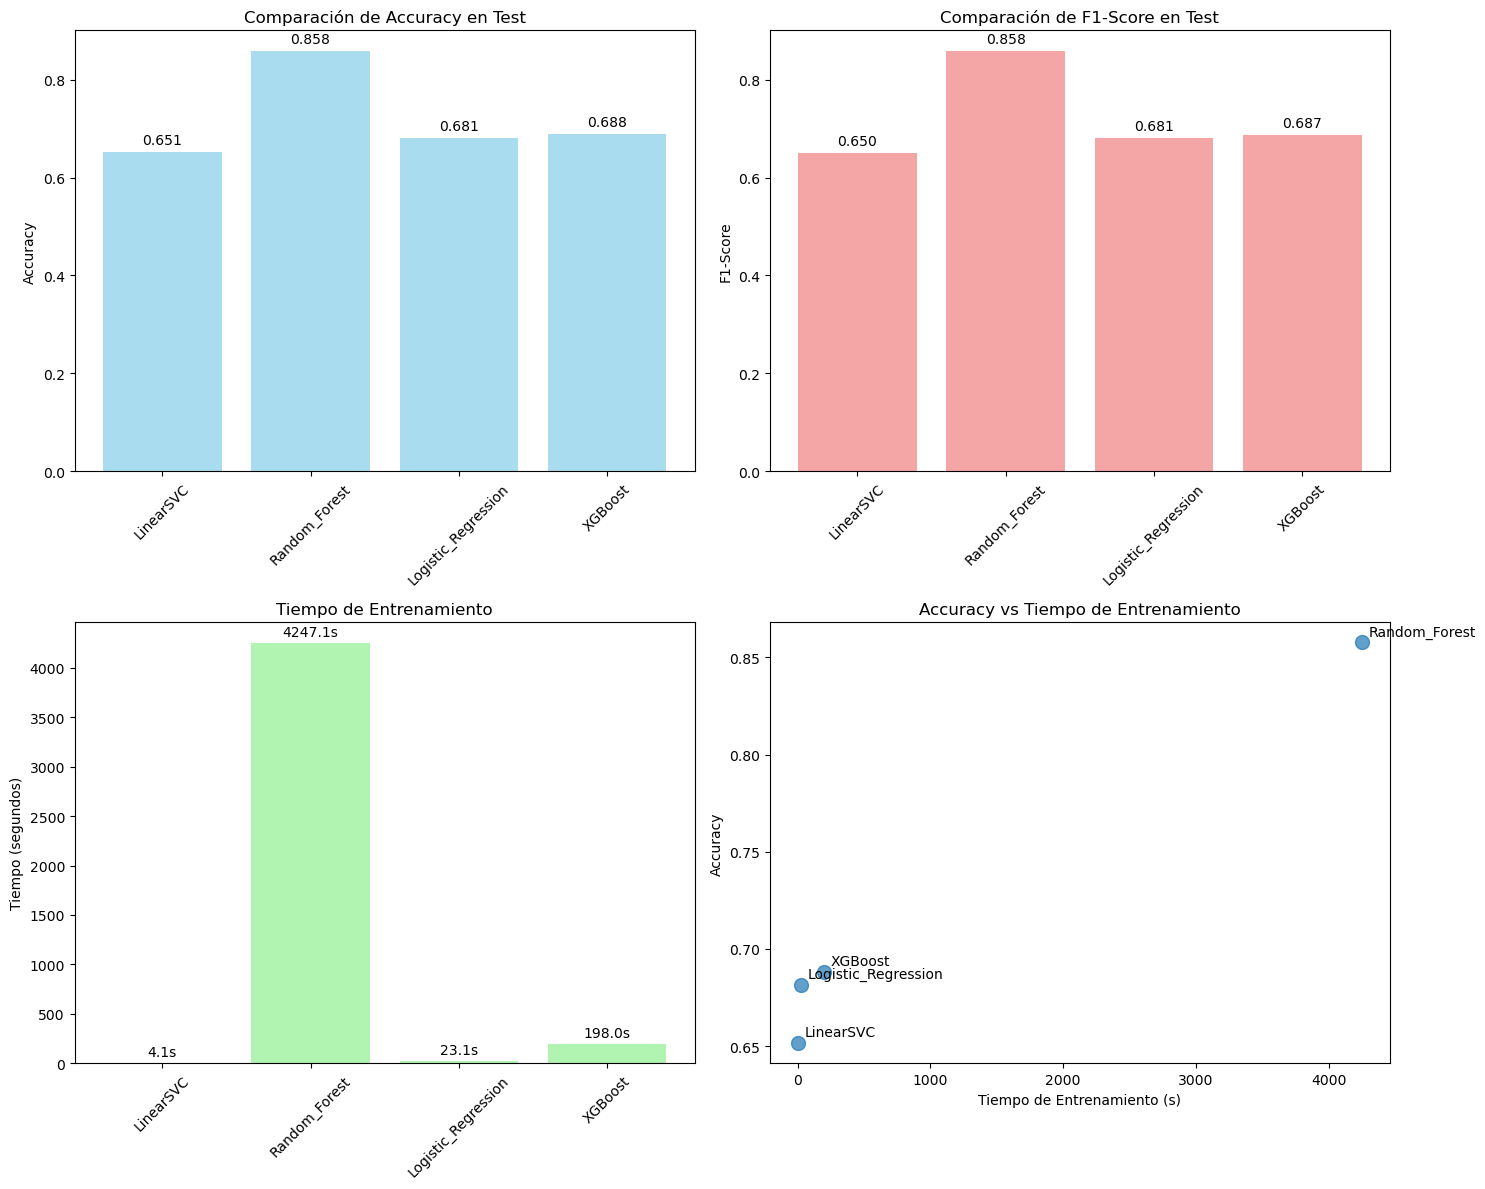

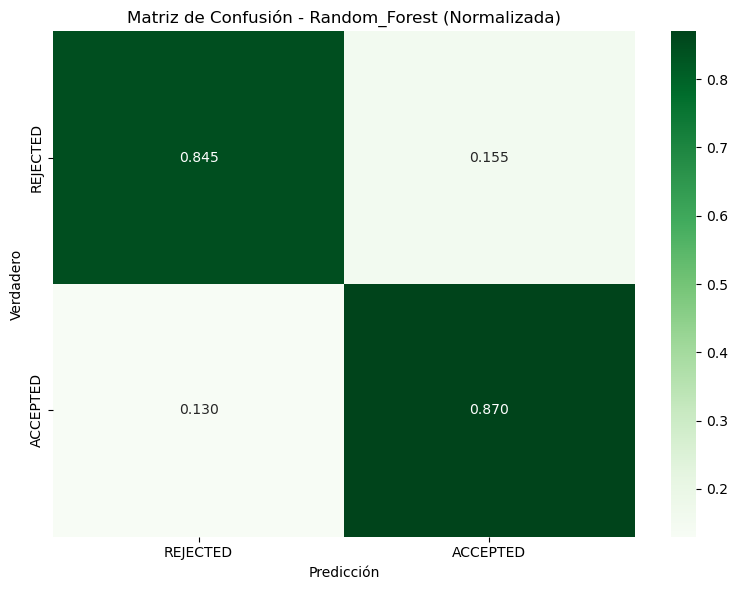

In [ ]:
summary = create_detailed_analysis(all_results, test_df)

In [ ]:
# all_results[best_model]

# 9. Reporte final

In [ ]:
# Tiempo total
total_time = time.time() - start_time
logger.info(f"Entrenamiento completado en {total_time:.2f} segundos")

# Mostrar mejores resultados
# el accuracy mas grande y da como resultado el key
best_model = max(summary.keys(), key=lambda x: summary[x]['test_accuracy'])
logger.info(f"Mejor modelo: {best_model} con accuracy: {summary[best_model]['test_accuracy']:.4f}")

2025-07-08 14:45:00,815 - INFO - Entrenamiento completado en 4604.84 segundos
2025-07-08 14:45:00,815 - INFO - Mejor modelo: Random_Forest con accuracy: 0.8577


In [ ]:
print("\n" + "="*50)
print("RESUMEN DE RESULTADOS")
print("="*50)
for model_name, metrics in summary.items():
    print(f"{model_name}:")
    print(f"  - Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"  - Test F1-Score: {metrics['test_f1']:.4f}")
    print(f"  - Tiempo de entrenamiento: {metrics['training_time']:.2f}s")
    print()


RESUMEN DE RESULTADOS
LinearSVC:
  - Test Accuracy: 0.6515
  - Test F1-Score: 0.6504
  - Tiempo de entrenamiento: 4.14s

Random_Forest:
  - Test Accuracy: 0.8577
  - Test F1-Score: 0.8577
  - Tiempo de entrenamiento: 4247.06s

Logistic_Regression:
  - Test Accuracy: 0.6814
  - Test F1-Score: 0.6809
  - Tiempo de entrenamiento: 23.09s

XGBoost:
  - Test Accuracy: 0.6883
  - Test F1-Score: 0.6871
  - Tiempo de entrenamiento: 198.03s

